# Exploring with Spark and Pandas

### Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [16]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.getOrCreate()

In [2]:
case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
dept = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)

In [3]:
# Joining the data frames:
df = case.join(dept, 'dept_division', 'left').join(source, 'source_id', 'left')

In [6]:
df.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

#### 1. How many different cases are there, by department?

In [15]:
case_dept = df.groupby(df.dept_division).count().toPandas()
case_dept.head()

,dept_division,count
0,Miscellaneous,46165
1,Solid Waste,816
2,Field Operations,119362
3,Streets,39193
4,Waste Collection,220696


In [29]:
case_dept = case_dept.sort_values(by='count', ascending=False).reset_index(drop=True)

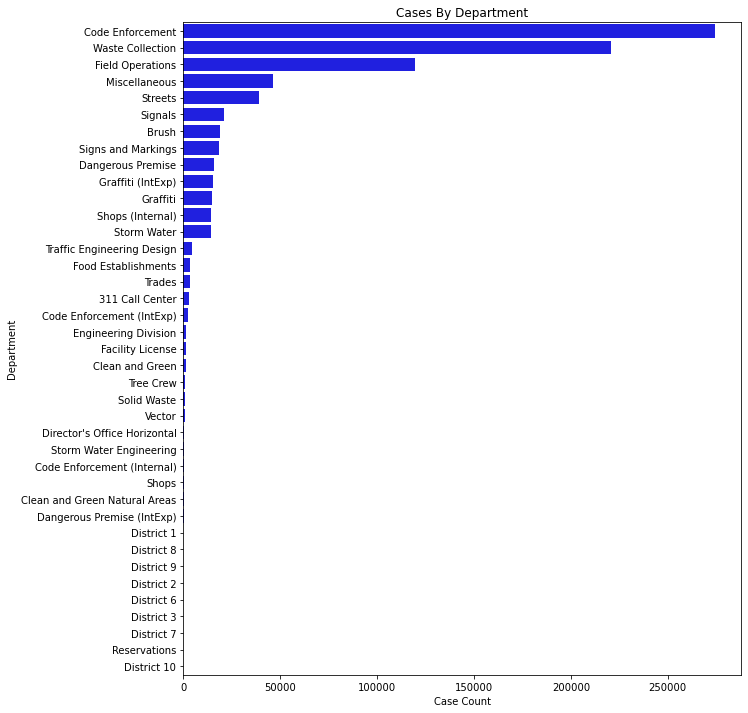

In [32]:
plt.figure(figsize=(10, 12))
sns.barplot(x="count", y="dept_division", data=case_dept, color="b")
plt.title('Cases By Department')
plt.xlabel('Case Count')
plt.ylabel('Department')
plt.show()

#### 2. Does the percentage of cases that are late vary by department?

#### 3. On average, how late are the late cases by department?

#### 4. What is the service type that is the most late? Just for Parks & Rec?

#### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

#### 6. Does whether or not its a weekend matter for when a case is opened/closed?

#### 7. On average, how many cases are opened a day for the Customer Service department?

#### 8. Does the number of service requests for the solid waste department vary by day of the week?